#### Creamos la red MesoNet e intentamos entrenarla para que distinga las imágenes reales de las que son fake

#### Importamos las bibliotecas necesarias

In [1]:
#! pip install mlxtend
#! pip install plot_keras_history
import os
import sys
import random
import numpy as np
import tensorflow as tf
import cv2
from sklearn.metrics import confusion_matrix, classification_report

from mlxtend.plotting import plot_confusion_matrix

from matplotlib import pyplot as plt
from tensorflow.keras.metrics import Precision, Recall, Accuracy

# Importamos algunas dependencias fundamentales de la API de tensorflow
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten, BatchNormalization, Dropout, LeakyReLU
import tensorflow as tf

from tensorflow.keras.losses import BinaryCrossentropy

from tensorflow.keras.optimizers import SGD, Adam

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from plot_keras_history import plot_history

2024-08-28 11:13:35.646696: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


#### Definimos las rutas de entrenamiento

In [2]:
ruta_actual = os.getcwd()
ruta_dataset_entrenamiento = os.path.join(ruta_actual,"Dataset","Train") 
ruta_dataset_validacion = os.path.join(ruta_actual,"Dataset","Validation")
ruta_dataset_test = os.path.join(ruta_actual,"Dataset","Test")

#Dentro de estos directorios se encuentran las carpetas de nombre 
#Real (contienen las imágenes reales y la carpeta 
#Fake (contiene las imágenes de los Fakes))

#### Creamos los generadores para los datasets haciendo uso de la API tf.data.Dataset. 

#### Realizamos el preprocesamiento de los datasets. Decidimos en una primera instancia no usar data augmentation.

In [3]:
#Dimensiones ancho y alto de las imágenes del dataset
ancho = 256
alto = 256

# Tamaño del lote
tamano_lote = 64

def cargar_preprocesar_imagen(ruta):
    parts = tf.strings.split(ruta, os.path.sep)
    etiqueta_tensor = parts[-2]
    if etiqueta_tensor.numpy() == b'Real':
        etiqueta_asignada = 1.0 
    else: 
        # En este caso etiqueta_tensor.numpy() == b'Real':
        etiqueta_asignada = 0.0
    
    etiqueta = tf.constant(etiqueta_asignada,dtype=tf.float32)
    imagen = tf.io.read_file(ruta)
    imagen = tf.image.decode_jpeg(imagen, channels=3)
    imagen = tf.image.resize(imagen, [alto, ancho])
    imagen = imagen / 255.0  # Normalizar a [0, 1]
    return imagen, etiqueta

# Función de envoltura para tf.py_function
def cargar_preprocesar_imagen_con_etiqueta(ruta):
    imagen, etiqueta = tf.py_function(cargar_preprocesar_imagen, [ruta], [tf.float32, tf.float32])
    imagen.set_shape((alto, ancho, 3))  # Asegurar que la imagen tenga la forma correcta
    etiqueta.set_shape(())  # La etiqueta es un escalar
    #etiqueta = tf.one_hot(etiqueta, len(clases))  # Convertir la etiqueta a one-hot encoding
    return imagen, etiqueta

######## DATASET ENTRENAMIENTO ############

# Cargar las imágenes desde el directorio de entrenamiento. Las imágenes son preprocesadas y preparadas para entrenar la red.
dataset_entrenamiento = tf.data.Dataset.list_files(ruta_dataset_entrenamiento + '/*/*.jpg')
dataset_entrenamiento = dataset_entrenamiento.map(cargar_preprocesar_imagen_con_etiqueta, num_parallel_calls=tf.data.AUTOTUNE)
#No hemos definido una función para hacer data augmentation
#dataset_entrenamiento = dataset_entrenamiento.map(aumento_imagenes, num_parallel_calls=tf.data.AUTOTUNE)

dataset_entrenamiento = dataset_entrenamiento.shuffle(buffer_size=1000)
#dataset_entrenamiento = dataset_entrenamiento.cache() #Nos quedamos sin RAM
dataset_entrenamiento = dataset_entrenamiento.batch(tamano_lote)
dataset_entrenamiento = dataset_entrenamiento.prefetch(buffer_size=tf.data.AUTOTUNE)
dataset_entrenamiento = dataset_entrenamiento.repeat()  # Añadir repeat()

######## DATASET VALIDACIÓN ############
# Cargar las imágenes desde el directorio de validación. Las imágenes son preprocesadas y preparadas para validar la red.
dataset_validacion = tf.data.Dataset.list_files(ruta_dataset_validacion + '/*/*.jpg')

dataset_validacion = dataset_validacion.map(cargar_preprocesar_imagen_con_etiqueta, num_parallel_calls=tf.data.AUTOTUNE)
#No necesitamos barajar el dataset de validación
#dataset_validacion = dataset_validacion.shuffle(buffer_size=100)
#dataset_validacion = dataset_validacion.cache() #No se debe usar (nos quedamos sin ram) 
dataset_validacion = dataset_validacion.batch(tamano_lote)
dataset_validacion = dataset_validacion.prefetch(buffer_size=tf.data.AUTOTUNE)
dataset_validacion = dataset_validacion.repeat()


######## DATASET TEST ############
# Cargar las imágenes desde el directorio de test. Si se desean entrenar otros modelos, se usarán estas imágenes para ver cual de ellos es el mejor
dataset_test = tf.data.Dataset.list_files(ruta_dataset_test + '/*/*.jpg')
dataset_test = dataset_test.map(cargar_preprocesar_imagen_con_etiqueta, num_parallel_calls=tf.data.AUTOTUNE)
#dataset_test = dataset_test.cache() #Nos quedamos sin ram si activamos esta opción
dataset_test = dataset_test.batch(tamano_lote)
dataset_test = dataset_test.prefetch(buffer_size=tf.data.AUTOTUNE)
dataset_test = dataset_test.repeat()

######## IMÁGENES DE CADA CONJUNTO ############
# Número de imágenes en el conjunto de entrenamiento, validación Y test
numero_imagenes_entrenamiento = sum([len(files) for r, d, files in os.walk(ruta_dataset_entrenamiento)])
numero_imagenes_validacion = sum([len(files) for r, d, files in os.walk(ruta_dataset_validacion)])
numero_imagenes_test = sum([len(files) for r, d, files in os.walk(ruta_dataset_test)])

2024-08-28 11:13:38.070311: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-28 11:13:38.144892: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-28 11:13:38.145007: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-28 11:13:38.146929: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compi

In [4]:
print(f"Número de imágenes para entrenamiento: {numero_imagenes_entrenamiento}")
print(f"Número de imágenes para validación: {numero_imagenes_validacion}")
print(f"Número de imágenes para test: {numero_imagenes_test}")


Número de imágenes para entrenamiento: 140002
Número de imágenes para validación: 39428
Número de imágenes para test: 10905


#### Definimos la arquitectura del modelo MesoNet

In [5]:
def MesoNet(tensor_entrada = Input((alto,ancho,3)) ):
    #Definimos el modelo de modo secuencial
    model = Sequential()

    #Añadimos el tensor de entrada con las dimensiones de entrada (por defecto imágenes en 3 canales de tamañi 224x224x3)
    model.add(tensor_entrada)

    #Primera capa de convolución, BatchNormalization y MaxPooling
    model.add(Conv2D(filters = 8, kernel_size=(3, 3),strides=(1, 1), padding='same', activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    #Segunda capa de convolución, BatchNormalization y MaxPooling
    model.add(Conv2D(filters = 8, kernel_size=(5, 5),strides=(1, 1), padding='same', activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    #Tercera capa de convolución, BatchNormalization y MaxPooling
    model.add(Conv2D(filters = 16, kernel_size=(5, 5),strides=(1, 1), padding='same', activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    #Cuarta y última capa de convolución, BatchNormalization y MaxPooling
    model.add(Conv2D(filters = 16, kernel_size=(5, 5),strides=(1, 1), padding='same', activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(4, 4), padding='same'))

    #Capas de flatten, capas densas, capa LeakyReLu y de Dropout
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(16))
    
    model.add(LeakyReLU(alpha = 0.1))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    #Terminamos en una única neurona con activación sigmoide (La activación también podría ser softmax)
    return model

#### Instanciamos el modelo MesoNet

In [6]:
modelo_MesoNet = MesoNet()
modelo_MesoNet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 8)       224       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 8)      32        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 8)       1608      
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 8)      32        
 hNormalization)                                                 
                                                        

#### Definimos el optimizador, función de pérdida, early stopping y disminución de learning rate si no mejora el entrenamiento. También realizamos la compilación del modelo.

##### Definimos la tasa de aprendizaje y el optimizador deseado (Adam)

In [7]:
tasa_aprendizaje = 0.001
optimizador =  Adam(learning_rate = tasa_aprendizaje )

##### Definimos parada temprana (EarlyStopping)

In [8]:
# Early stopping
parada_temprana = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

##### Definimos la caida del learning rate si el val_loss no mejora tras 5 épocas

In [9]:
# Reduce Learning rate on Plateau
reducir_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)


#### Compilamos el modelo

In [10]:
modelo_MesoNet.compile(optimizer=optimizador,loss = BinaryCrossentropy(), metrics=["accuracy",Recall(), Precision()] )

#### Calculamos los pasos de entrenamiento, de validación y del test del modelo

In [11]:
if numero_imagenes_entrenamiento % tamano_lote == 0:
    pasos_entrenamiento = numero_imagenes_entrenamiento // tamano_lote
else:
    pasos_entrenamiento = numero_imagenes_entrenamiento // tamano_lote +1

if numero_imagenes_validacion % tamano_lote == 0:
    pasos_validacion = numero_imagenes_validacion // tamano_lote
else:
    pasos_validacion = numero_imagenes_validacion // tamano_lote +1

if numero_imagenes_test % tamano_lote == 0:
    pasos_test = numero_imagenes_test // tamano_lote
else:
    pasos_test = numero_imagenes_test // tamano_lote +1


print(f"Número de pasos de entrenamiento para un batch size de {tamano_lote}: {pasos_entrenamiento}")
print(f"Número de pasos de validación para un batch size de {tamano_lote}: {pasos_validacion}")
print(f"Número de pasos de test para un batch size de para un batch size de {tamano_lote}: {pasos_test}")

Número de pasos de entrenamiento para un batch size de 64: 2188
Número de pasos de validación para un batch size de 64: 617
Número de pasos de test para un batch size de para un batch size de 64: 171


#### Entrenamos por 100 épocas la red. El entrenamiento parará antes a causa del early stopping

In [12]:
# Entrenamiento del modelo
numero_epocas = 100


historia_MesoNet = modelo_MesoNet.fit(
    dataset_entrenamiento,
    epochs=numero_epocas,
    validation_data=dataset_validacion,
    steps_per_epoch=pasos_entrenamiento,
    validation_steps=pasos_validacion,
    callbacks=[parada_temprana, reducir_lr]
)

Epoch 1/100


2024-08-28 11:13:43.677306: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204
2024-08-28 11:13:44.847951: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2024-08-28 11:13:44.847971: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2024-08-28 11:13:44.848051: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-08-28 11:13:46.010561: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2188/2188 [==============================] - 575s 260ms/step - loss: 0.4514 - accuracy: 0.7855 - recall: 0.7888 - precision: 0.7836 - val_loss: 0.3360 - val_accuracy: 0.8569 - val_recall: 0.9072 - val_precision: 0.8251 - lr: 0.0010
Epoch 2/100
2188/2188 [==============================] - 565s 257ms/step - loss: 0.2196 - accuracy: 0.9140 - recall: 0.9127 - precision: 0.9150 - val_loss: 0.2496 - val_accuracy: 0.8922 - val_recall: 0.8401 - val_precision: 0.9386 - lr: 0.0010
Epoch 3/100
2188/2188 [==============================] - 565s 257ms/step - loss: 0.1758 - accuracy: 0.9325 - recall: 0.9335 - precision: 0.9316 - val_loss: 0.2243 - val_accuracy: 0.9104 - val_recall: 0.8947 - val_precision: 0.9242 - lr: 0.0010
Epoch 4/100
2188/2188 [==============================] - 566s 257ms/step - loss: 0.1558 - accuracy: 0.9415 - recall: 0.9438 - precision: 0.9395 - val_loss: 0.2423 - val_accuracy: 0.8968 - val_recall: 0.8176 - val_precision: 0.9724 - lr: 0.0010
Epoch 5/100
2188/2188 [=============

#### Guardamos los pesos de la red MesoNet entrenada

In [13]:
modelo_MesoNet.save("modelo_MesoNet_final.h5")

#### Podemos cargar los pesos del modelo

In [14]:
modelo_cargado = load_model("modelo_MesoNet_final.h5")

### Analizamos los resultados (accuracy, recall, precision, f1_score, matriz de confusión, ...) sobre el conjunto de entrenamiento y validación

###### Se muestran gráficas con el loss, accuracy, precision y recall del entrenamiento

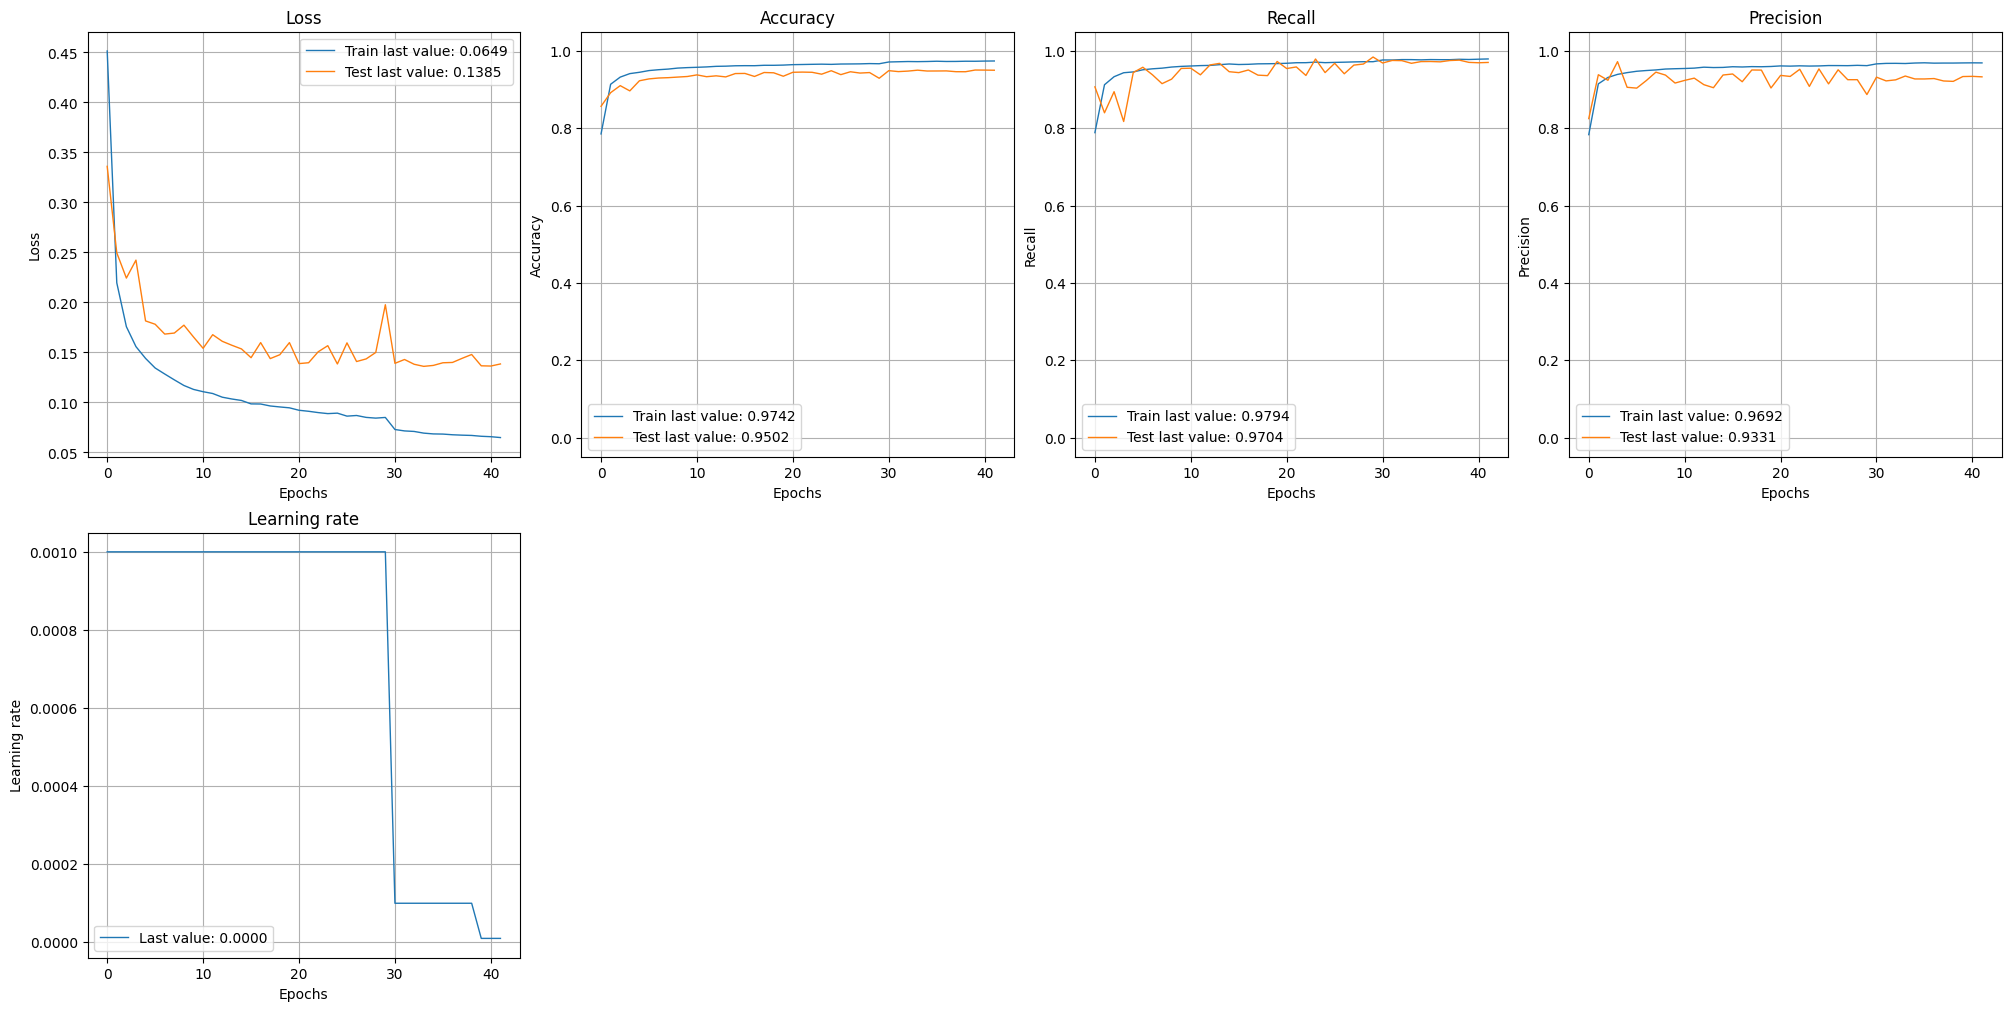

In [15]:
#Mostramos gráficas de interes del entrenamiento en función de las épocas

#from plot_keras_history import plot_history
plot_history(historia_MesoNet)
plt.show()

##### Calculamos la matriz de confusión sobre el conjunto de entrenamiento. Primero hacemos el computo necesario

In [16]:
#Vamos a iterar sobre batches dataset para calcular los valores de las predicciones y las etiquetas
#(no lo hacemos directamente ya que se baraja el dataset cada vez que se recorre y no se podría obtener el valor de las etiquetas)

#Creamos arrays vacíos
prediccion_entrenamiento = np.array([])
etiquetas_entrenamiento = np.array([])

generador_entrenamiento = dataset_entrenamiento.take(pasos_entrenamiento).as_numpy_iterator()

# Silenciamos la salida
sys.stdout = open(os.devnull, 'w')

for iteracion in range(pasos_entrenamiento):
    
    lote = generador_entrenamiento.next()
    imagenes = lote[0]
    etiquetas = lote[1]
    
    #Calculamos la prediccion del modelo sobre el batch
    prediccion_lote = modelo_cargado.predict(imagenes)
    prediccion_lote = np.round(prediccion_lote.reshape(1,-1).flatten())
    prediccion_entrenamiento = np.concatenate((prediccion_entrenamiento, prediccion_lote), axis=0)

    etiquetas_entrenamiento = np.concatenate((etiquetas_entrenamiento, etiquetas), axis=0)

# Restauraramos la salida
sys.stdout = sys.__stdout__

[[68469  1532]
 [ 1049 68952]]
              precision    recall  f1-score   support

         0.0     0.9849    0.9781    0.9815     70001
         1.0     0.9783    0.9850    0.9816     70001

    accuracy                         0.9816    140002
   macro avg     0.9816    0.9816    0.9816    140002
weighted avg     0.9816    0.9816    0.9816    140002

[[18315  1326]
 [  630 19157]]
              precision    recall  f1-score   support

         0.0     0.9667    0.9325    0.9493     19641
         1.0     0.9353    0.9682    0.9514     19787

    accuracy                         0.9504     39428
   macro avg     0.9510    0.9503    0.9504     39428
weighted avg     0.9509    0.9504    0.9504     39428

[[5058  434]
 [ 714 4699]]
              precision    recall  f1-score   support

         0.0     0.8763    0.9210    0.8981      5492
         1.0     0.9154    0.8681    0.8911      5413

    accuracy                         0.8947     10905
   macro avg     0.8959    0.8945    0.

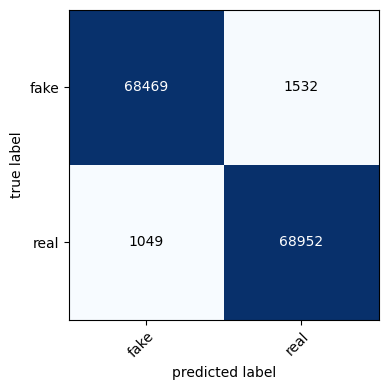

In [17]:
#Calculamos la matriz de confusión sobre el conjunto de entrnamiento y la mostramos
matriz_confusion_entrenamiento = confusion_matrix(etiquetas_entrenamiento,prediccion_entrenamiento)

print(matriz_confusion_entrenamiento)

%matplotlib inline

etiquetas = ['fake','real']

plot_confusion_matrix(conf_mat = matriz_confusion_entrenamiento, figsize = (4,4), class_names = etiquetas, show_normed = False)
plt.tight_layout()

##### Imprimimos los resultados de clasification report

In [18]:
print(classification_report(etiquetas_entrenamiento,prediccion_entrenamiento, digits = 4))

##### Calculamos la matriz de confusión sobre el conjunto de validación. Primero hacemos el computo necesario

In [19]:
#Vamos a iterar sobre batches dataset para calcular los valores de las predicciones y las etiquetas
#(no lo hacemos directamente ya que se baraja el dataset cada vez que se recorre y no se podría obtener el valor de las etiquetas)

#Creamos arrays vacíos
prediccion_validacion = np.array([])
etiquetas_validacion = np.array([])

generador_validacion = dataset_validacion.take(pasos_validacion).as_numpy_iterator()

# Silenciamos la salida
sys.stdout = open(os.devnull, 'w')

for iteracion in range(pasos_validacion):
    
    lote = generador_validacion.next()
    imagenes = lote[0]
    etiquetas = lote[1]
    
    #Calculamos la prediccion del modelo sobre el batch
    prediccion_lote = modelo_cargado.predict(imagenes)
    prediccion_lote = np.round(prediccion_lote.reshape(1,-1).flatten())
    prediccion_validacion = np.concatenate((prediccion_validacion, prediccion_lote), axis=0)

    etiquetas_validacion = np.concatenate((etiquetas_validacion, etiquetas), axis=0)

# Restauraramos la salida
sys.stdout = sys.__stdout__

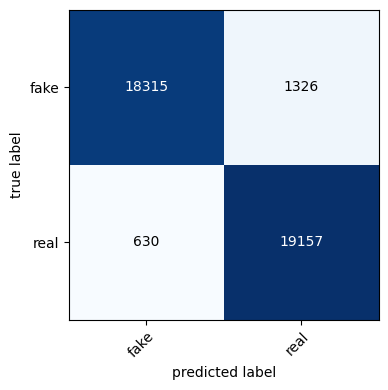

In [20]:
#Calculamos la matriz de confusión en validación y la mostramos
matriz_confusion_validacion = confusion_matrix(etiquetas_validacion,prediccion_validacion)

print(matriz_confusion_validacion)

%matplotlib inline

etiquetas = ['fake','real']

plot_confusion_matrix(conf_mat = matriz_confusion_validacion, figsize = (4,4), class_names = etiquetas, show_normed = False)
plt.tight_layout()

##### Imprimimos los resultados de clasification report

In [21]:
print(classification_report(etiquetas_validacion,prediccion_validacion, digits = 4))

## Hacemos exactamente lo mismo pero sobre el conjunto de test. Esto lo podemos usar para comparar los resultados con otras arquitecturas de red distintas a MesoNet.

### Analizamos los resultados (accuracy, recall, precision, f1_score, matriz de confusión, ...) sobre el conjunto de test. Para ello mostramos la matriz de confusión y el informe de clasificación

In [22]:
#Vamos a iterar sobre batches dataset para calcular los valores de las predicciones y las etiquetas
#(no lo hacemos directamente ya que se baraja el dataset cada vez que se recorre y no se podría obtener el valor de las etiquetas)

#Creamos arrays vacíos
prediccion_test = np.array([])
etiquetas_test = np.array([])

generador_test = dataset_test.take(pasos_test).as_numpy_iterator()

# Silenciamos la salida
sys.stdout = open(os.devnull, 'w')

for iteracion in range(pasos_test):
    
    lote = generador_test.next()
    imagenes = lote[0]
    etiquetas = lote[1]
    
    #Calculamos la prediccion del modelo sobre el batch
    prediccion_lote = modelo_cargado.predict(imagenes)
    
    prediccion_lote = np.round(prediccion_lote.reshape(1,-1).flatten())
    prediccion_test = np.concatenate((prediccion_test, prediccion_lote), axis=0)

    etiquetas_test = np.concatenate((etiquetas_test, etiquetas), axis=0)

# Restauraramos la salida
sys.stdout = sys.__stdout__

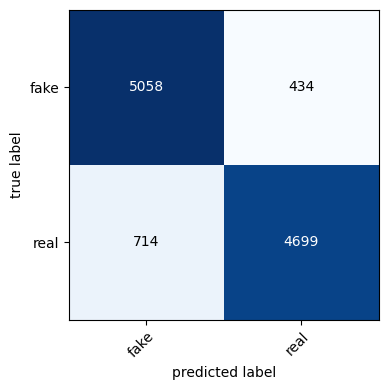

In [23]:
#Calculamos la matriz de confusión sobre el conjunto de test y la mostramos
matriz_confusion_test = confusion_matrix(etiquetas_test,prediccion_test)

print(matriz_confusion_test)

%matplotlib inline

etiquetas = ['fake','real']

plot_confusion_matrix(conf_mat = matriz_confusion_test, figsize = (4,4), class_names = etiquetas, show_normed = False)
plt.tight_layout()

##### Imprimimos los resultados de clasification report

In [24]:
print(classification_report(etiquetas_test,prediccion_test, digits = 4))

### OBSERVACIONES SOBRE LOS RESULTADOS:

#### Mostramos imágenes del dataset de validación, junto con la predicción del modelo para las imágenes clasificadas correctamente y las clasificadas erroneamente.

In [25]:

#Imágenes reales clasificadas correctamente por el modelo
real_correcto = []
prediccion_real_correcto = []

#Imágenes fake clasificadas correctamente por el modelo
fake_correcto = []
prediccion_fake_correcto = []

#Imágenes reales clasificadas como fake por el modelo
real_incorrecto = []
prediccion_real_incorrecto = []

#Imágenes fake clasificadas como reales por el modelo
fake_incorrecto = []
prediccion_fake_incorrecto = []

In [26]:
# Tomamos 12 imágenes de cada tipo 

generador_validacion = dataset_validacion.take(pasos_validacion).as_numpy_iterator()
for iteracion in range(pasos_validacion):
    print(f"Iteracion número: {iteracion}")
    
    lote = generador_validacion.next()
    imagenes = lote[0]
    etiquetas = lote[1]
    
    # Silenciamos la salida
    sys.stdout = open(os.devnull, 'w')
    for indice, imagen in enumerate(imagenes):

        #Calculamos la prediccion del modelo sobre las imágenes hasta obtener 12 de cada tipo
        prediccion_imagen = modelo_cargado.predict(np.expand_dims(imagen,axis=0))
        prediccion_imagen = prediccion_imagen.flatten()[0]
        etiqueta_imagen = etiquetas[indice]

        #Imágenes reales que fueron clasificadas correctamente por el modelo
        if prediccion_imagen >= 0.5 and etiqueta_imagen == 1:
            if len(real_correcto)<12:
                real_correcto.append(imagen)
                prediccion_real_correcto.append(prediccion_imagen)
        
        #Imágenes fake que fueron clasificadas correctamente por el modelo
        elif prediccion_imagen < 0.5 and  etiqueta_imagen == 0:
            if len(fake_correcto)<12:
                fake_correcto.append(imagen)
                prediccion_fake_correcto.append(prediccion_imagen)
        #Imágenes reales que fueron clasificadas incorrectamente como fake por el modelo
        elif prediccion_imagen < 0.5 and  etiqueta_imagen == 1:
            if len(real_incorrecto)<12:
                real_incorrecto.append(imagen)
                prediccion_real_incorrecto.append(prediccion_imagen) 

        #Imágenes fake que fueron clasificadas incorrectamente como reales por el modelo
        elif prediccion_imagen >= 0.5 and  etiqueta_imagen == 0:
            if len(fake_incorrecto)<12:
                fake_incorrecto.append(imagen)
                prediccion_fake_incorrecto.append(prediccion_imagen)
    # Restauraramos la salida
    sys.stdout = sys.__stdout__
    
    if len(real_correcto)==12 and len(fake_correcto)==12 and len(real_incorrecto)==12 and len(fake_incorrecto)==12:
        break #Salimos del bucle si tenemos 12 imágenes de cada una de las cuatro categorías


In [27]:
def mostrar_imagenes(imagenes,predicciones):
    fig = plt.figure(figsize=(12,6))
    
    for indice,imagen in enumerate(imagenes):
        fig.add_subplot(3,4,indice+1)
        plt.imshow(np.squeeze(imagen))
        plt.xlabel(f"Predicción del modelo: \n{predicciones[indice]:.4f}")
        plt.tight_layout()
        ax = plt.gca()
        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])
    plt.show()
    return


### Visualizamos ejemplos de las cuatro clases de imágenes

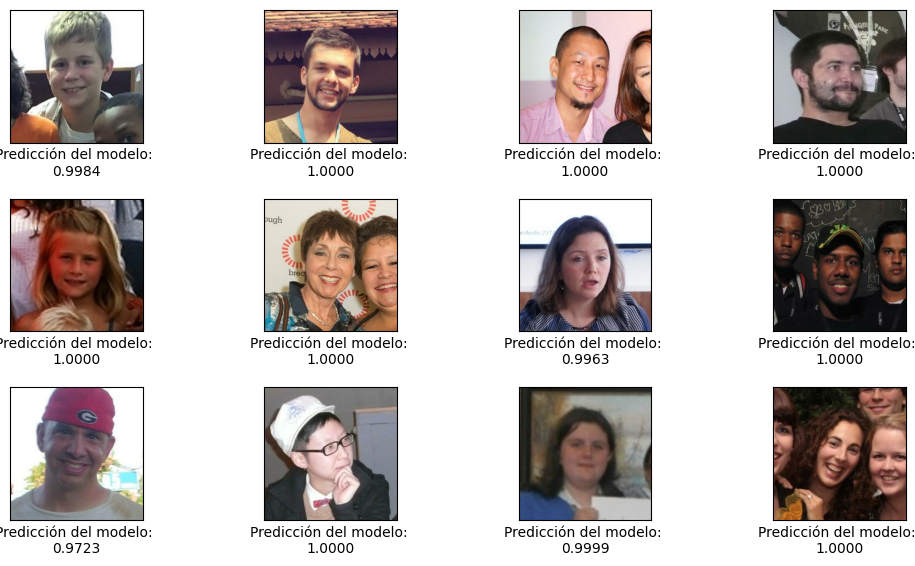

In [28]:
#Imágenes reales clasificadas correctamente por el modelo MesoNet
mostrar_imagenes(real_correcto, prediccion_real_correcto)


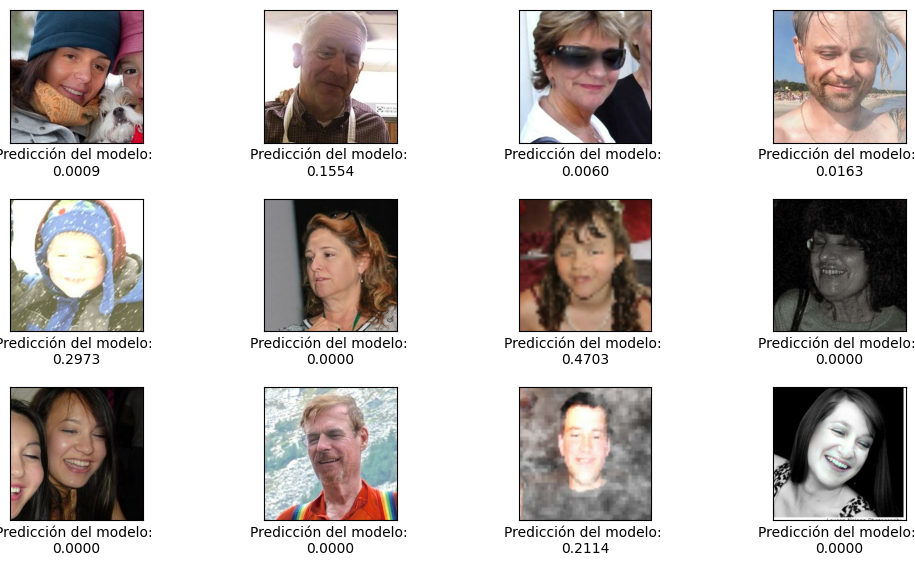

In [29]:
#Imágenes fake clasificadas correctamente por el modelo MesoNet
mostrar_imagenes(fake_correcto, prediccion_fake_correcto)


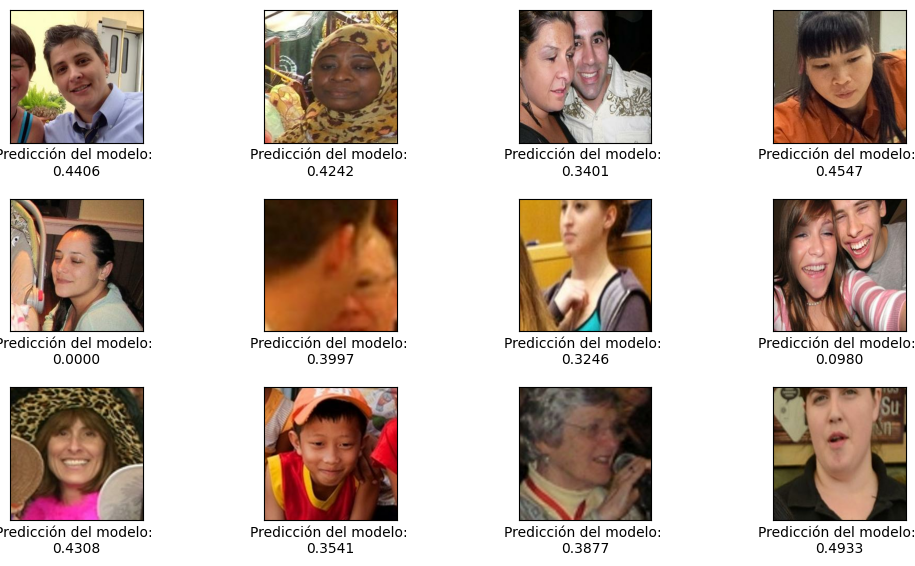

In [30]:
#Imágenes reales clasificadas incorrectamente por el modelo como fake
mostrar_imagenes(real_incorrecto, prediccion_real_incorrecto)

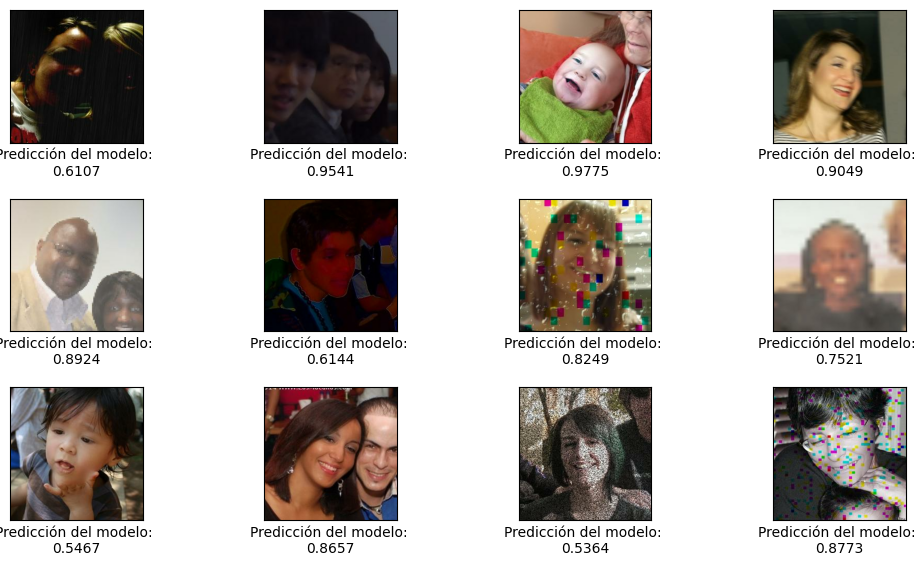

In [31]:
#Imágenes fake clasificadas incorrectamente por el modelo como reales
mostrar_imagenes(fake_incorrecto, prediccion_fake_incorrecto)

#### Observaciones